<div style="text-align: center;">
    
# **TRAINING - CS4619 Assignment, 2025**
#### **Alexander Goodison (Student Number: 121308756)**

<p style="text-align: center;">
    The following is my submission for the training section of the CS4619 Assignment. Unless otherwise cited, all work is my own or derived from the course lectures.</p>
</div>

<hr />
&nbsp

### **Notebook Setup**

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.keras.applications import ResNet50, InceptionV3, Xception
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess, decode_predictions as resnet_decode
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess, decode_predictions as inception_decode
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess, decode_predictions as xception_decode

In [ ]:
import os
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "./drive/My Drive/Colab Notebooks/"
else:
  base_dir = "./assets"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set seed for reproducable results
from tensorflow.random import set_seed
set_seed(121308756)

In [ ]:
# Specify where the training, validation and test images are contained
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [ ]:
# Convert these directiores to image datasets
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="binary", image_size=(400, 400))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="binary", image_size=(400, 400))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="binary", image_size=(400, 400))

Found 126 files belonging to 2 classes.
Found 190 files belonging to 2 classes.
Found 192 files belonging to 2 classes.


<hr />
&nbsp

### **Assignment Overview**
In thinking of which classes to use for this assignment, I thought it would be a good opporunity to use my experince at my US-based startup, Homeplan, to create something useful for our day-to-day environment. At Homeplan, we require vast amounts of data about each home, which sometimes may be outdated or completely incorrect.

One attribute of a home that is essential for us to know is if that home has a pool or not. Public parcel data is available about all homes in the US, but sometimes this may not be the most reliable.

For this assignment, I will explore using satallite imagery of homes in the US to determine the presence of a swimming pool. Obviously, there may be cases where the pool is not visible from satellite imagery (it may be covered by trees) or the pool may be indoors... but for the sake of this assignment, we will ignore those cases.


#### **Obtaining the images**
It made sense to choose homes in Los Angeles, California for this assignment, as quite simply, lots of homes have pools there. I figured that it was also important to only consider properties from one location as using homes from multiple states/cities may confuse the model, and it may learn to detect the wrong things - styles of property architecture can vary vastly across the US, which can lead to unwanted issues.

Los Angeles County publish a dataset of all properties within it: https://data.lacounty.gov/documents/4d67b154ae614d219c58535659128e71/about

This dataset is available in the form of a Shapefile, which I convert to a GeoJSON file with the library `geopandas`. This results in a file with all of the properties in LA county and the coordinates of their property boundaries.

I then write a python script that imports this GeoJSON file, and selects a random sample of 1000 properties. It then uses the [Mapbox Static Images API](https://docs.mapbox.com/api/maps/static-images/) to obtain a 400x400 satellite image for each of these properties.

As a final step, we use the GeoJSON coordainte array to mask the property in focus in each particular satellite image. This avoids the issue where an image may show neighbouring properties, that may or may not have a pool. This results in images as shown below.

Then after some manual work, I pick out 200 images that display a property with a pool and 200 images of properties that have no pool.

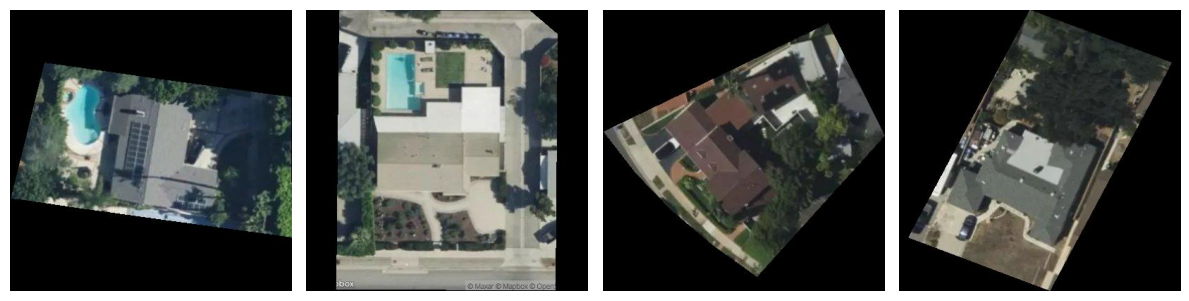

In [ ]:
image_paths = [
    os.path.join(base_dir, "train/pool/2283012023.jpg"), # Has a pool
    os.path.join(base_dir, "train/pool/2678013002.jpg"), # Has a pool
    os.path.join(base_dir, "train/no_pool/4019011025.jpg"), # No pool
    os.path.join(base_dir, "train/no_pool/5617002011.jpg")  # No pool
]

images = [Image.open(img) for img in image_paths]
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()

<hr />
&nbsp

### **Model Selection and Tweaking**
In finding the best model as part of transfer learning, it made sense to look at those [available as part of Keras](https://keras.io/api/applications/#usage-examples-for-image-classification-models) and try a few.

For all models tested in this notebook, I implemented data augmentation. I decided that a random flip and rotation of the image would not compromise the integrity of the image itself.

In [ ]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

As for the callbacks used in all models in this nodebook, I implemented:
- Early Stopping
- [**ReduceLROnPlateau:**](https://keras.io/api/callbacks/reduce_lr_on_plateau/) This reduces the learning rate when a given metric, val_loss in our case, has stopped improving. Using this, I saw improvements in the val_accuracy of various models, so I decided to keep it in.

In [ ]:
model_callbacks = [
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.00001)
]

##### **InceptionV3**

Inception V3 is a model available as part of Keras for use in transfer learning. It was developed at Google and is listed across the internet as one of the best models of its kind: https://www.geeksforgeeks.org/top-pre-trained-models-for-image-classification/. Hence, I thought it would be a reasonable model to start with.

Docs: https://keras.io/api/applications/inceptionv3/

In [ ]:
# Instantiate InceptionV3 architecture
inception_base = InceptionV3(weights="imagenet", include_top=False)

In [ ]:
## Compose the network w/ InceptionV3

inputs = Input(shape=(400, 400, 3)) # Define the input size
x = data_augmentation(inputs) # Apply image augmentation (flip & rotation)
x = Resizing(299, 299)(x) # Resize the image (Inception requires images of size 299x299)

x = inception_preprocess(x) # Apply Inception preprocessing
x = inception_base(x) # Add the Inception base network

# Keras docs recommended adding a GlobalAveragePooling2D and fully connected layer: https://keras.io/api/applications/#usage-examples-for-image-classification-models%5D
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)

# Sigmoid activation function for output later as we're doing binary classification
outputs = Dense(1, activation="sigmoid")(x)
inception_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Freeze weights in base layer to avoid losing already learned features
for layer in inception_base.layers:
    layer.trainable = False

In [ ]:
# Compile the model (binary crossentropy is used as loss function as we are doing binary classification)
inception_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the model on the training dataset and using the validation dataset to measure its accuracy
inception_model_history = inception_model.fit(train_dataset, epochs=30,
                    validation_data=val_dataset,
                    callbacks=model_callbacks,
                    verbose=1)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5030 - loss: 0.8040 - val_accuracy: 0.5053 - val_loss: 0.8009 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.6088 - loss: 0.7319 - val_accuracy: 0.5000 - val_loss: 0.8320 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - accuracy: 0.6502 - loss: 0.6752 - val_accuracy: 0.6579 - val_loss: 0.6233 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - accuracy: 0.7449 - loss: 0.5829 - val_accuracy: 0.7105 - val_loss: 0.6086 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step - accuracy: 0.6098 - loss: 0.6166 - val_accuracy: 0.5737 - val_loss: 0.6588 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - accuracy: 0.5685 - loss: 0.6865 - val_accuracy: 0.7000 - val_loss: 0.5951 - learning_rate: 1.0000e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - accuracy: 0.7148 - loss: 0

From the graph below we can see that the accuracy on the test set is somewhat higher than the val_accuracy, and a similar story can be seen for loss vs val_loss. This can be signs that the model is overfitting.

<Axes: >

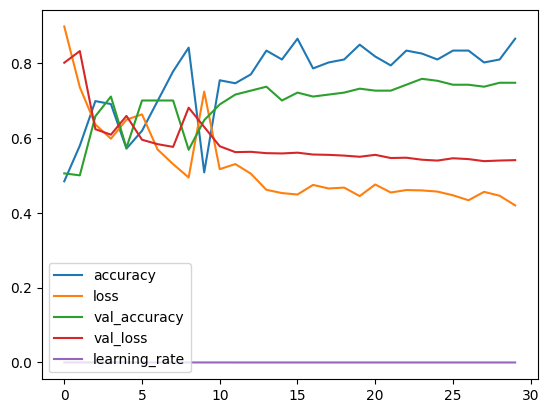

In [ ]:
pd.DataFrame(inception_model_history.history).plot()

##### **ResNet50**
I also experimented using ResNet50, as we did in the lectures, as the base layer for my network.

In [ ]:
# Load ResNet50 layers
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Compose network
inputs = Input(shape=(400, 400, 3)) # Define the input layer with the original image shape (400x400)
x = data_augmentation(inputs) # Augment images
x = Resizing(224, 224)(x) # Resize the image to size required by ResNet50

x = resnet_preprocess(x)
x = resnet50_base(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)
resnet_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
resnet50_base.trainable = False # Freeze ResNet50 base layers

In [ ]:
resnet_model.summary() # Preview model

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 400, 400, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 400, 400, 3)    │              0 │ input_layer_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing_12 (Resizing)    │ (None, 224, 224, 3)    │              0 │ sequential_2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224)       │              0 │ resizing_12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 224, 224)       │              0 │ resizing_12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 224, 224)       │              0 │ resizing_12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_49 (Add)              │ (None, 224, 224, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_49[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 100352)         │              0 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 1)              │        100,353 │ flatten_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,688,065 (90.36 MB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
resnet_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
%%time

# Train the model on the training dataset and using the validation dataset to measure its accuracy
resnet_model_history = resnet_model.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=model_callbacks,
                verbose=1)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5838 - loss: 1.5741 - val_accuracy: 0.5474 - val_loss: 0.8088 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 565ms/step - accuracy: 0.6405 - loss: 0.7781 - val_accuracy: 0.6316 - val_loss: 0.8064 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 558ms/step - accuracy: 0.6645 - loss: 0.8127 - val_accuracy: 0.6368 - val_loss: 0.7611 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - accuracy: 0.6622 - loss: 0.8723 - val_accuracy: 0.6632 - val_loss: 0.6340 - learning_rate: 1.0000e-04
CPU times: user 12.3 s, sys: 629 ms, total: 12.9 s
Wall time: 19.4 s


This produced some mediocre results, with unimpressive accuracy. Let's see if unfreezing some of the base layers can improve the situation.

<Axes: >

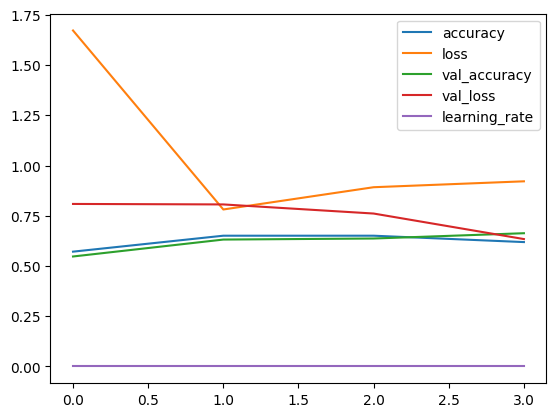

In [ ]:
pd.DataFrame(resnet_model_history.history).plot()

In [ ]:
# Unfreeze base layers that are not BatchNormalization layers
for layer in resnet50_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [ ]:
resnet_model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 400, 400, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 400, 400, 3)    │              0 │ input_layer_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing_12 (Resizing)    │ (None, 224, 224, 3)    │              0 │ sequential_2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224)       │              0 │ resizing_12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 224, 224)       │              0 │ resizing_12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 224, 224)       │              0 │ resizing_12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_49 (Add)              │ (None, 224, 224, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_49[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 100352)         │              0 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 1)              │        100,353 │ flatten_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,788,420 (90.75 MB)

 Trainable params: 23,581,825 (89.96 MB)

 Non-trainable params: 106,240 (415.00 KB)

 Optimizer params: 100,355 (392.02 KB)

In [ ]:
resnet_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
%%time

# Train whole model on training data
resnet_model_history = resnet_model.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=model_callbacks,
                verbose=1)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5092 - loss: 2.6045 - val_accuracy: 0.4947 - val_loss: 0.7905 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 750ms/step - accuracy: 0.5270 - loss: 0.7500 - val_accuracy: 0.6737 - val_loss: 0.6488 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 620ms/step - accuracy: 0.6571 - loss: 0.6521 - val_accuracy: 0.6526 - val_loss: 0.6442 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step - accuracy: 0.5252 - loss: 0.6982 - val_accuracy: 0.6789 - val_loss: 0.6193 - learning_rate: 1.0000e-04
CPU times: user 19.5 s, sys: 1.03 s, total: 20.5 s
Wall time: 24.8 s


Results are still mediocre. Before tweaking this network, I decided to try one final model...

<Axes: >

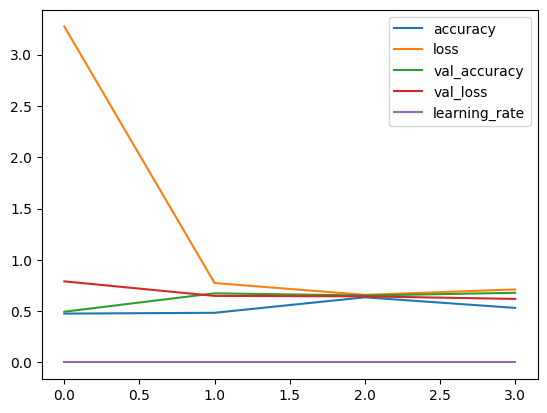

In [ ]:
pd.DataFrame(resnet_model_history.history).plot()

##### **Xception**

Finally, I used Xception, which is said to be an [extreme and improved version of InceptionV3.](https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568). This model proved to be the best of the three I tested, so I decided to do most of my tweaking only on this one (to save time as refitting the model is tedious).

Docs: https://keras.io/api/applications/xception/

In [ ]:
# Instantiate Xception architecture
xception_base = Xception(weights="imagenet", include_top=False)

To reduce any possible overfitting I tried two methods:
- Adding dropout layers to the network (as seen commented out below)
- Reducing number of nodes in dense fully-connected layer from 1024 to 512.

Both attempts yielded no noticable improvement.

In [ ]:
## Compose the network w/ Xception

inputs = Input(shape=(400, 400, 3)) # Define the input size
x = data_augmentation(inputs) # Apply image augmentation (flip & rotation)
x = Resizing(299, 299)(x) # Resize the image (Xception requires images of size 299x299)

x = xception_preprocess(x) # Apply Xception preprocessing
x = xception_base(x) # Add the Xception base network

x = GlobalAveragePooling2D()(x)

# x = Dropout(0.5)(x) # Dropout with a rate of 50% to reduce over fitting
x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x) # Add another Dropout before the final layer

# Sigmoid activation function for output later as we're doing binary classification
outputs = Dense(1, activation="sigmoid")(x)
xception_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Freeze weights in base layer to avoid losing already learned features
for layer in xception_base.layers:
    layer.trainable = False

As part of model compilation, I tried two different optimizers: RMSprop and Adam. These seemed to be the most popular optimizers from what I had seen across my research. I found an [example online](https://www.kaggle.com/code/alphasingal/satellite-image-classification-with-inceptionv3#Configuration_) of someone using Adam as an optimizer so I thought it would be worth trying.

From switching between the two, both produced similar results, but RMSprop resulted in slightly better accuracy, so I decided to stick with it.

In [ ]:
xception_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
# xception_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
%%time

# Train the model on the training dataset and using the validation dataset to measure its accuracy
xception_model_history = xception_model.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)], # Only using EarlyStopping helped
                verbose=1)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6896 - loss: 0.6039 - val_accuracy: 0.6947 - val_loss: 0.6264
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7682 - loss: 0.5785 - val_accuracy: 0.7105 - val_loss: 0.6195
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 930ms/step - accuracy: 0.7893 - loss: 0.5639 - val_accuracy: 0.7000 - val_loss: 0.6159
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 935ms/step - accuracy: 0.7254 - loss: 0.5680 - val_accuracy: 0.6895 - val_loss: 0.6186
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 913ms/step - accuracy: 0.7525 - loss: 0.5360 - val_accuracy: 0.6947 - val_loss: 0.6085
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7777 - loss: 0.5215 - val_accuracy: 0.7368 - val_loss: 0.5993
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7693 - loss: 0.5121 - val_accuracy: 0.7263 - val_loss: 0.5966
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7066 - loss: 0.5396 - val_accuracy: 0.6842 - val_loss: 0.5936
Epoch 9

After much tweaking, this produced some... ok-ish results, so my hope was that unfreezing some of the base layers could improve the model.

<Axes: >

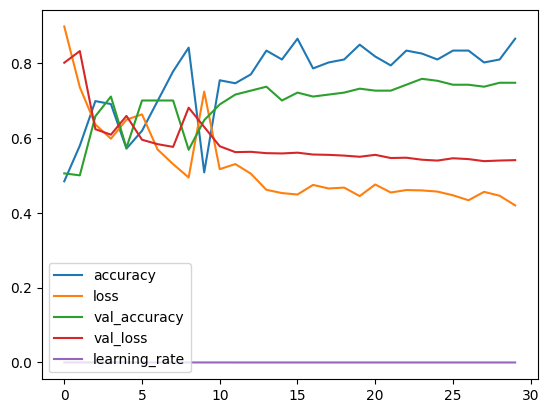

In [ ]:
pd.DataFrame(inception_model_history.history).plot()

In [ ]:
# Unfreeze base layers that are not BatchNormalization layers
for layer in xception_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [ ]:
# Recompile Xception model
xception_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
%%time

# Train the model on the training dataset and using the validation dataset to measure its accuracy
xception_model_history = xception_model.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)],
                verbose=1)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7427 - loss: 1.1695 - val_accuracy: 0.5053 - val_loss: 0.7818
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5498 - loss: 0.7341 - val_accuracy: 0.5053 - val_loss: 0.7869
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4574 - loss: 0.7742 - val_accuracy: 0.6000 - val_loss: 0.6585
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5819 - loss: 0.6526 - val_accuracy: 0.5947 - val_loss: 0.6291
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6176 - loss: 0.6310 - val_accuracy: 0.5789 - val_loss: 0.5964
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7047 - loss: 0.5211 - val_accuracy: 0.8474 - val_loss: 0.3539
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8299 - loss: 0.4524 - val_accuracy: 0.9053 - val_loss: 0.3802
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9246 - loss: 0.2746 - val_accuracy: 0.9526 - val_loss: 0.1605
Epoch 9/30
4

Now this graph looks more like it. The accuracy is great for both training and test set and loss values are both low (but there is a noticable difference still between loss and val_loss.. so maybe some overfitting still?). This is the best model produced thus far.

<Axes: >

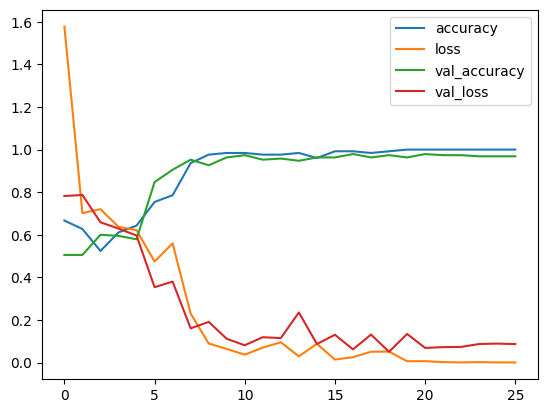

In [159]:
pd.DataFrame(xception_model_history.history).plot()

<hr />
&nbsp

### **Testing**
Now that I am happy with the model, it's time to evaluate it on the test dataset, and save it locally.

In [161]:
test_loss, test_acc = xception_model.evaluate(test_dataset)
test_acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.9763 - loss: 0.0610


0.9739583134651184

In [162]:
xception_model.save(os.path.join(base_dir, "best_network.keras"))